In [26]:
# from http://lang.hm/maslow/v-plotter.py
# updated to python3
# needed to 'pip3 install pillow' to be able to mport Image and ImageDraw

In [27]:
#!/usr/bin/env python

#created by Bill Ola Rasmussen http://2e5.com/plotter/V/design/
# modified by David Lang (david@lang.hm) to add grid and tweak parameters to match Maslow CNC
# the modified version is at http://lang.hm/maslow/v-plotter.py

import sys
from PIL import Image
from PIL import ImageDraw
from math import sqrt,sin,cos,acos,atan2,degrees,fabs

In [32]:
# setup the constants
version=1.7
outputFile="v-plotter-out.png"
# width and height are in pixels
# picked these values as creating an image that will fit on a HD screen at full resolution and fit the maslow 4' x 8' workspace
width,height=1900,1100
# border is in pixels, this is really pretty meaningless, but it was in the original code and you can't get really close to the edges or the motors anyway, so I've left this in place (David Lang)
border=32
# how low and how high the tension is allowed to be, measured in terms of multiples of the pen/sled weight
# for the maslow CNC with a ~10Kg sled and motors that produce 20Kg/cm of torque, these values seem appropriate 
lo,hi=.25,1.8
#max error betwen letting the length grow by 1 and the plotted position
# the maslow has 8148 pulses/rev and is trying to achieve 1/64" accuracy with a 10 tooth type 25 roller chain sprocket.
# 50.9 'steps' = 1/64"
max=50.9
# spacing in ft to create 1ftx1ft grid
# this is the first place where 'real world' dimensions come into play. The units here are arbitrary, they create a grid based on whatever units this spacing is in. So if you put a spacing in ft, the resulting major grids will be in ft. If you put in a dimension in hands, the resulting major grid will be in hands

# on the maslow CNC, the current spacing is defined as 9.77 ft
spacing=9.77
# how many subgrids per grid. For Imperial 12 inches/foot
# These subgrids are also arbitrary divisions. If the grid is in ft, then =12 would make subgrids in inches. If the grid is in meters, then 100 would be centimeters
subgrid=12
#scale computes how many pixles per unit of spacing
scale=(width-border)/spacing
# define offsets so that the grid is centered on the image and shift it vertically
xoff=0.5*((width-border)%int(scale)+border+(int(spacing)%2*scale))
# yoffset is manually set so that you can make a major grid line appear at the bottom of the top curve to make it easier to see how a board would fit
yoff=-.5*scale
# V line end points
v1=border/2,border/2
v2=width-border/2-1,border/2

In [33]:
def cross(draw,p,n):
    c="#000000"
    draw.line((p[0]-n,p[1]-n,p[0]+n,p[1]+n),c)
    draw.line((p[0]+n,p[1]-n,p[0]-n,p[1]+n),c)

def drawFixtures(draw):
    # border of calculation pixels
    draw.rectangle([border-1,border-1,width-border,height-border],"#FFFFFF","#000000")
    # V line end points
    cross(draw,v1,border/4)
    cross(draw,v2,border/4)

def drawGrid(draw):
    c="#D0D0D0"
    for x in range(-1 * subgrid, int(width/scale*subgrid)+1):
        draw.line((x*scale/subgrid+xoff,0,x*scale/subgrid+xoff,height),c)
    for y in range(0, int(height/scale*subgrid)+subgrid):
        draw.line((0,yoff+y*scale/subgrid,width,yoff+y*scale/subgrid),c)
    c="#000000"
    for x in range(0, int(width/scale)+1):
        draw.line((x*scale+xoff,0,x*scale+xoff,height),c)
    for y in range(0, int(height/scale)+2):
        draw.line((0,yoff+y*scale,width,yoff+y*scale),c)
    draw.line((width/2,0,width/2,height),"#FF0000")

def lineTensions(a1,a2):
    d=cos(a1)*sin(a2)+sin(a1)*cos(a2)
    return cos(a2)/d,cos(a1)/d

def tensionOk(p):
    # find angles
    a1=atan2(p[1]-v1[1],p[0]-v1[0])
    a2=atan2(p[1]-v2[1],v2[0]-p[0])
    # strings tension check
    t1,t2=lineTensions(a1,a2)
    return lo<t1<hi and lo<t2<hi

def dx(p1,p2):
    return sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2);

def calcPointB(a,b,c):
    alpha=acos((b**2+c**2-a**2)/(2*b*c))
    return b*cos(alpha)+v1[0],b*sin(alpha)+v1[1]

def resolutionOk(p):
    # law of cosines calculation and nomenclature
    c=dx(v1,v2)
    b=dx(v1,p)
    a=dx(v2,p)
    # sanity check
    err=.00000000001
    pc=calcPointB(a,b,c)
    #assert p[0]-err<pc[0]<p[0]+err
    #assert p[1]-err<pc[1]<p[1]+err
    # calculate mapped differences
    db=dx(p,calcPointB(a,b+1,c)) # extend left line by 1 unit
    da=dx(p,calcPointB(a+1,b,c)) # extend right line by 1 unit
    return db<max and da<max # line pull of 1 unit does not move x,y by more than max

def calcPixel(draw,p):
    t=tensionOk(p)
    r=resolutionOk(p)
    if not t and not r:
        draw.point(p,"#3A5FBD")
    if not t and r:
        draw.point(p,"#4876FF")
    if t and not r:
        draw.point(p,"#FF7F24")
    # default to background color

def drawPixels(draw):
    for y in range(border,height-border):
        sys.stdout.write('.')
        sys.stdout.flush()
        for x in range(border,width-border):
            calcPixel(draw,(x,y))
    sys.stdout.write('\n')

def main():
    print("V plotter map, version", version)

    image = Image.new("RGB",(width,height),"#D0D0D0")
    draw = ImageDraw.Draw(image)

    drawFixtures(draw)
    drawPixels(draw)
    drawGrid(draw)

    image.save(outputFile,"PNG")
    print("map image written to", outputFile)
    print("done.")

In [34]:
#if __name__ == "__main__":
#    main()
main()

V plotter map, version 1.7
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

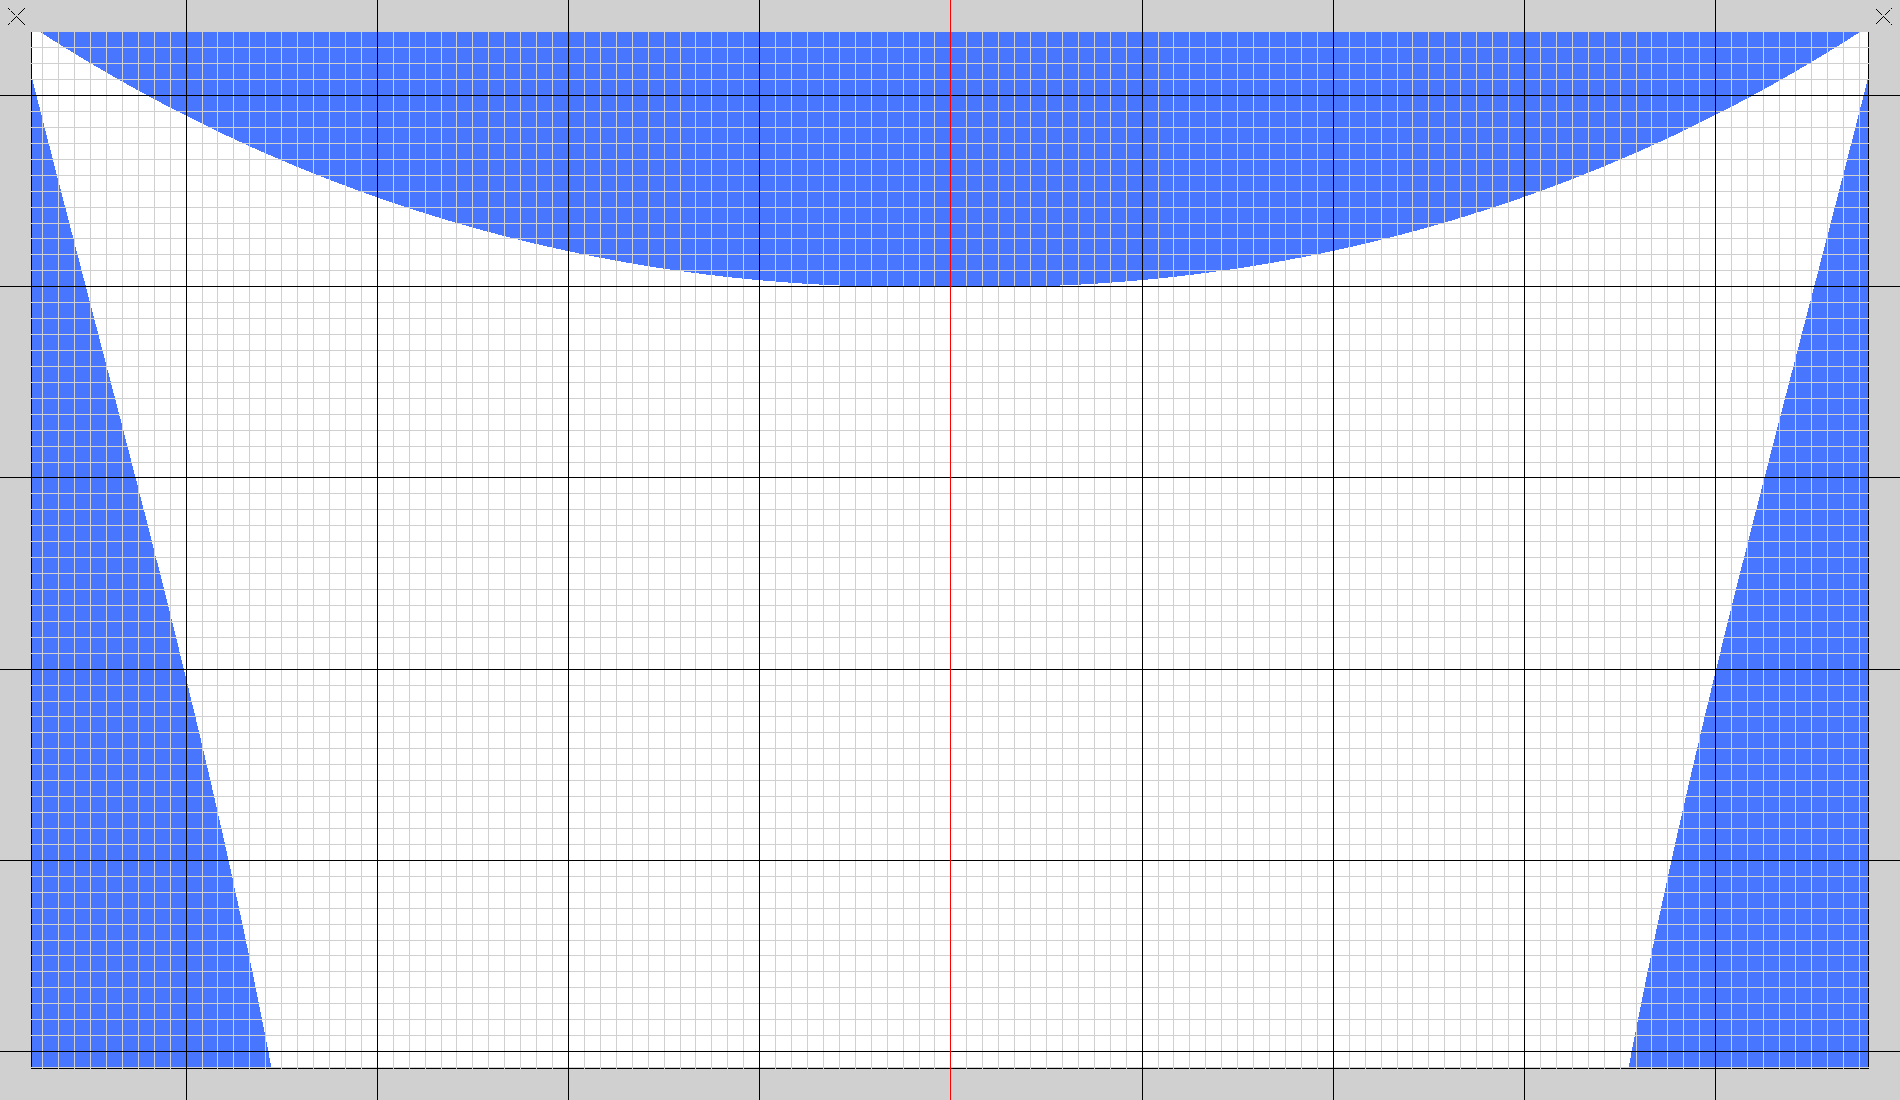

In [35]:
import IPython
pil_img = IPython.display.Image(filename=outputFile)
display(pil_img)